In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import distance

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [2]:
data_dir = "../data/processed"
image_dir = "../images"

In [3]:
df_cmpds_original = pd.read_pickle(os.path.join(data_dir, "BBBC021_original_compounds_props.pickle"))
df_cmpds_original = df_cmpds_original.fillna(-999)

In [4]:
df_cmpds_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Columns: 214 entries, Image_Metadata_Compound to fr_urea
dtypes: float64(106), int64(104), object(4)
memory usage: 58.6+ KB


In [5]:
compounds = df_cmpds_original["Image_Metadata_Compound"].to_numpy()
descriptors = df_cmpds_original[df_cmpds_original.columns[4:]].to_numpy()
moas = df_cmpds_original["Image_Metadata_MoA"].unique()

In [8]:
def create_descr_dist_matix(descr):
    scaler = MinMaxScaler()
    scaled_descr = scaler.fit_transform(descr)
    dist_matrix = np.zeros((len(scaled_descr), len(scaled_descr)))
    for i in range(len(scaled_descr)):
        for j in range(len(scaled_descr)):
            dist_matrix[i][j] = distance.cosine(scaled_descr[i], scaled_descr[j])
    return dist_matrix

In [9]:
distance_matrix = create_descr_dist_matix(descriptors)

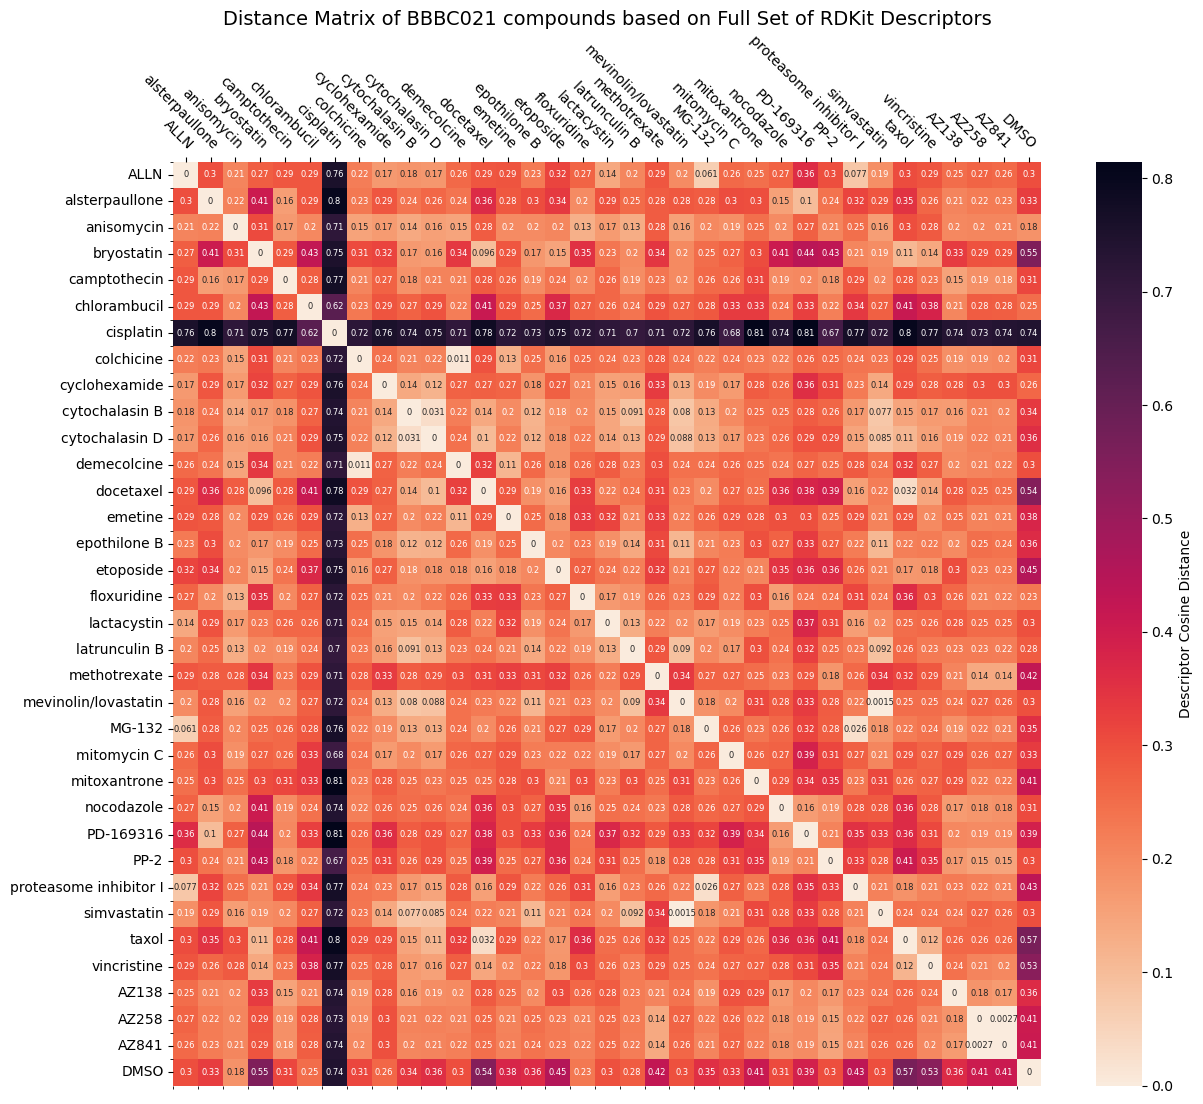

In [19]:
fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(distance_matrix, 
            annot=True, 
            annot_kws={"fontsize":6, "ha": "center"}, 
            fmt=".2g", 
            cbar_kws={'label': 'Descriptor Cosine Distance'},
            cmap="rocket_r",
            ax=ax)
ax.set_yticks(range(len(compounds)), minor=True)
ax.set_yticklabels(compounds)
ax.set_xticks(range(len(compounds)), minor=True)
ax.set_xticklabels(compounds)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title("Distance Matrix of BBBC021 compounds based on Full Set of RDKit Descriptors", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

plt.show()

In [20]:
fig.savefig(os.path.join(image_dir, "Descriptor_distance_matrix.png"))

In [16]:
def generate_moa_dist_matrix(df, moa, ax):
    cmpd_list = df[df["Image_Metadata_MoA"] == moa]["Image_Metadata_Compound"].to_numpy()
    cmpd_idx = [i for i, c in enumerate(compounds) if c in cmpd_list]
    moa_dist = np.zeros((len(cmpd_idx), len(cmpd_idx)))
    for k in range(len(cmpd_idx)):
        for l in range(len(cmpd_idx)):
            moa_dist[k][l] = distance_matrix[cmpd_idx[k]][cmpd_idx[l]]

    sns.heatmap(moa_dist, 
                annot=True, 
                annot_kws={"fontsize":8, "ha": "center"}, 
                fmt=".4g", 
                cbar_kws={'label': 'Descriptor Cosine Distance', 'shrink': 0.6},
                cmap="rocket_r",
                square=True,
                vmin=0,
                vmax=10,
                ax=ax)
    ax.set_yticks(range(len(cmpd_idx)), minor=True)
    ax.set_yticklabels(cmpd_list)
    ax.set_xticks(range(len(cmpd_idx)), minor=True)
    ax.set_xticklabels(cmpd_list)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.set_title(f"Distance Matrix MoA - {moa}", fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

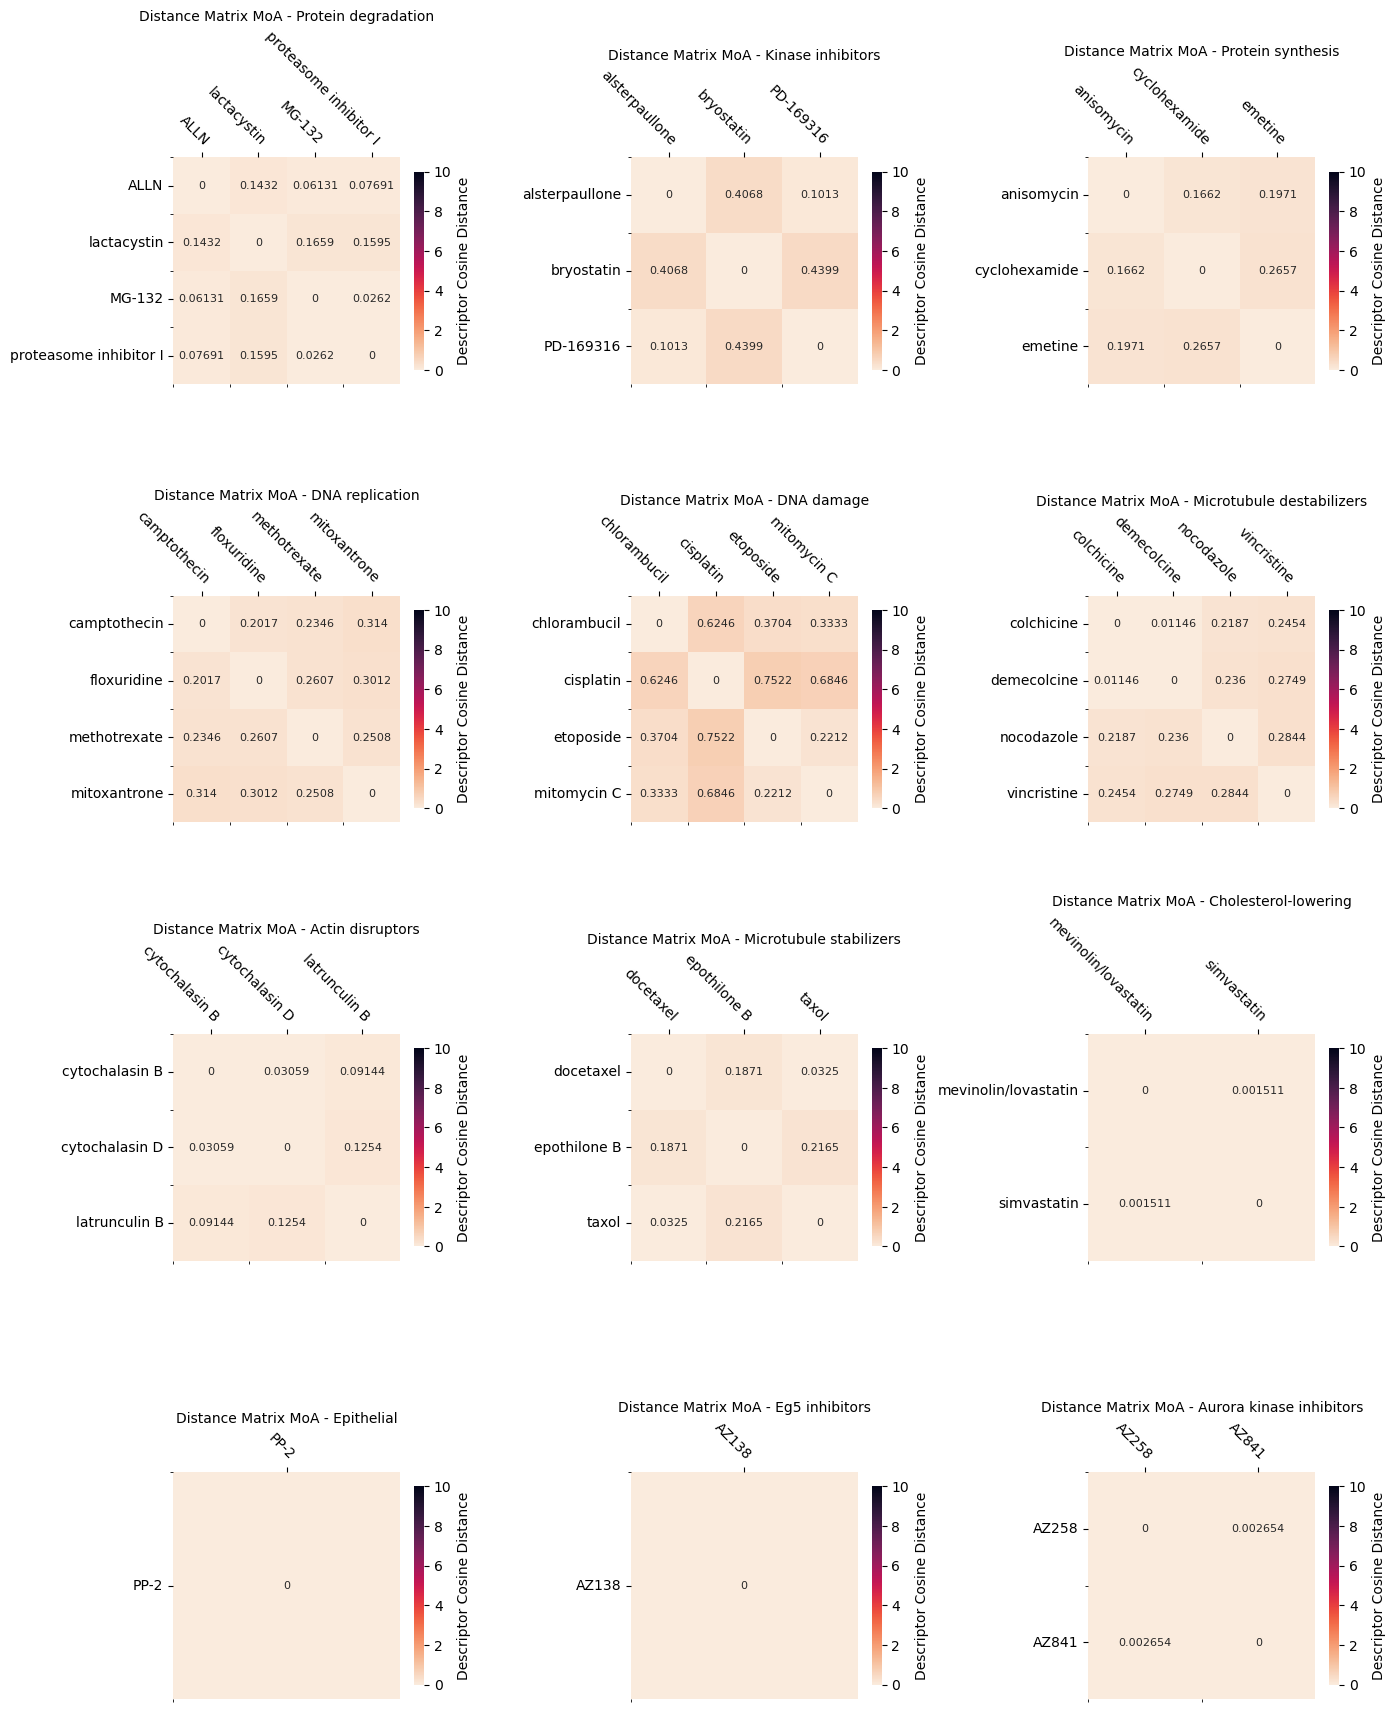

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,18))
for i, ax in enumerate(axes.flat):
    if moas[i] == "DMSO":
        continue
    # print(moas[i])
    generate_moa_dist_matrix(df_cmpds_original, moas[i], ax)
plt.tight_layout()
plt.show()

In [18]:
fig.savefig(os.path.join(image_dir, "Descriptor_distance_matrix_by_MoA.png"))

---

In [40]:
random_seed = 42

scaler = MinMaxScaler()
scaled_descr = scaler.fit_transform(descriptors)

In [41]:
cluster_range = range(2,35)
silhouette_score_list = list()
cluster_label_dict = dict()

for num_clust in cluster_range:
    km_clust = KMeans(n_clusters=num_clust, random_state=random_seed, n_init='auto')
    cluster_labels = km_clust.fit_predict(scaled_descr)
    cluster_label_dict[num_clust] = cluster_labels
    score = silhouette_score(scaled_descr, cluster_labels)
    silhouette_score_list.append([num_clust, score])

df_cluser_score = pd.DataFrame(silhouette_score_list, columns=["Num Clusters", "Silhouette Score"])

In [42]:
df_cluser_score.loc[df_cluser_score["Silhouette Score"].idxmax(), :]

Num Clusters        24.000000
Silhouette Score     0.211934
Name: 22, dtype: float64

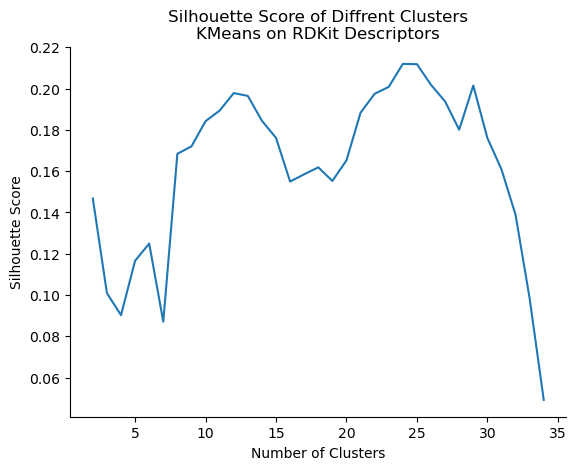

In [43]:
fig, ax = plt.subplots()
sns.lineplot(data=df_cluser_score, x="Num Clusters", y="Silhouette Score", ax=ax)
ax.set_ylabel("Silhouette Score")
ax.set_xlabel("Number of Clusters")
ax.set_title("Silhouette Score of Diffrent Clusters\nKMeans on RDKit Descriptors")
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [44]:
fig.savefig(os.path.join(image_dir, "Descriptor_KMeans_silhoutte_score.png"))

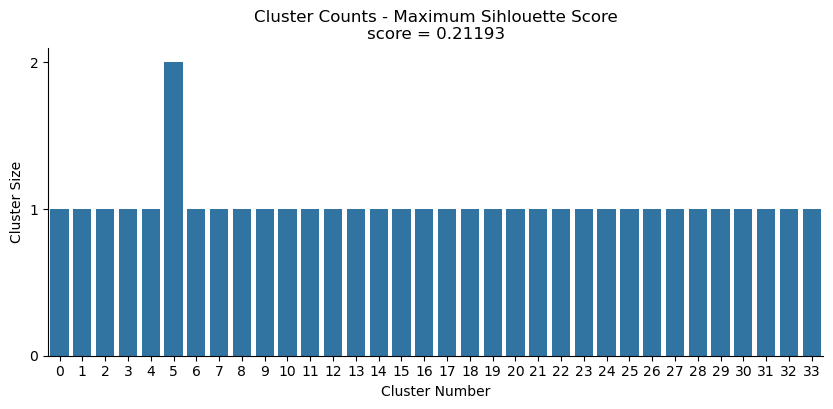

In [45]:
num_cluster = int(df_cluser_score.loc[df_cluser_score["Silhouette Score"].idxmax(), :]["Num Clusters"])
clusters = cluster_label_dict[num_clust]

unique, counts = np.unique(clusters, return_counts=True)
df_cluster_counts = pd.DataFrame.from_records(data=list(zip(unique, counts)), columns=["Cluster", "Count"])

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=df_cluster_counts, x="Cluster", y="Count", ax=ax)
ax.set_yticks(range(3), labels=[0, 1, 2])
ax.set_ylabel("Cluster Size")
ax.set_xlabel("Cluster Number")
ax.set_title(f"Cluster Counts - Maximum Sihlouette Score\nscore = {df_cluser_score.loc[df_cluser_score['Silhouette Score'].idxmax(), :]['Silhouette Score']:.5f}")
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [46]:
fig.savefig(os.path.join(image_dir, "Descriptor_KMeans_cluster_counts.png"))

In [47]:
cluster_max_count = np.where(clusters == 5)[0]
df_cluster_max = df_cmpds_original.iloc[cluster_max_count, :]

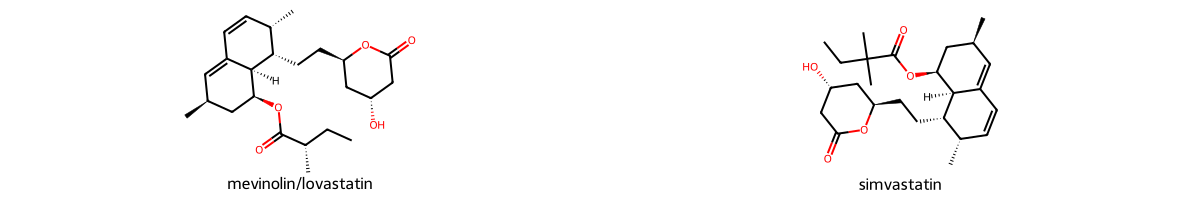

In [48]:
Draw.MolsToGridImage(
    df_cluster_max["mol"].to_list(),
    molsPerRow=2,
    subImgSize=(600, 200),
    legends=df_cluster_max["Image_Metadata_Compound"].to_list(),
)